## Simulate non-isoplanatic imaging for LOW at 100MHz.

### A set of model components are drawn from GLEAM. An ionospheric screen model is used to calculate the pierce points of the two stations in an interferometer for a given component. The model visibilities are calculated directly, and screen phase applied to obtain the corrupted visibility.

In [ ]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import export_blockvisibility_to_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client



In [5]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='w',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/timcornwell/results/low-sims-mpc.log'

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
n_workers=16
c = get_dask_Client(
    memory_limit=64 * 1024 * 1024 * 1024, n_workers=n_workers, threads_per_worker=1)
arlexecute.set_client(c)
# Initialise logging on the workers. This appears to only work using the process scheduler.
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:32915': None,
 'tcp://127.0.0.1:33987': None,
 'tcp://127.0.0.1:35063': None,
 'tcp://127.0.0.1:35503': None,
 'tcp://127.0.0.1:35777': None,
 'tcp://127.0.0.1:35941': None,
 'tcp://127.0.0.1:36833': None,
 'tcp://127.0.0.1:38865': None,
 'tcp://127.0.0.1:38875': None,
 'tcp://127.0.0.1:39377': None,
 'tcp://127.0.0.1:39843': None,
 'tcp://127.0.0.1:40709': None,
 'tcp://127.0.0.1:41039': None,
 'tcp://127.0.0.1:42787': None,
 'tcp://127.0.0.1:42859': None,
 'tcp://127.0.0.1:43669': None}

### Set up the observation: 10 minutes at transit, with 10s integration. Skip 5/6 points to avoid out station redundancy

Configuration has 398 stations
Thinned configuration has 92 stations


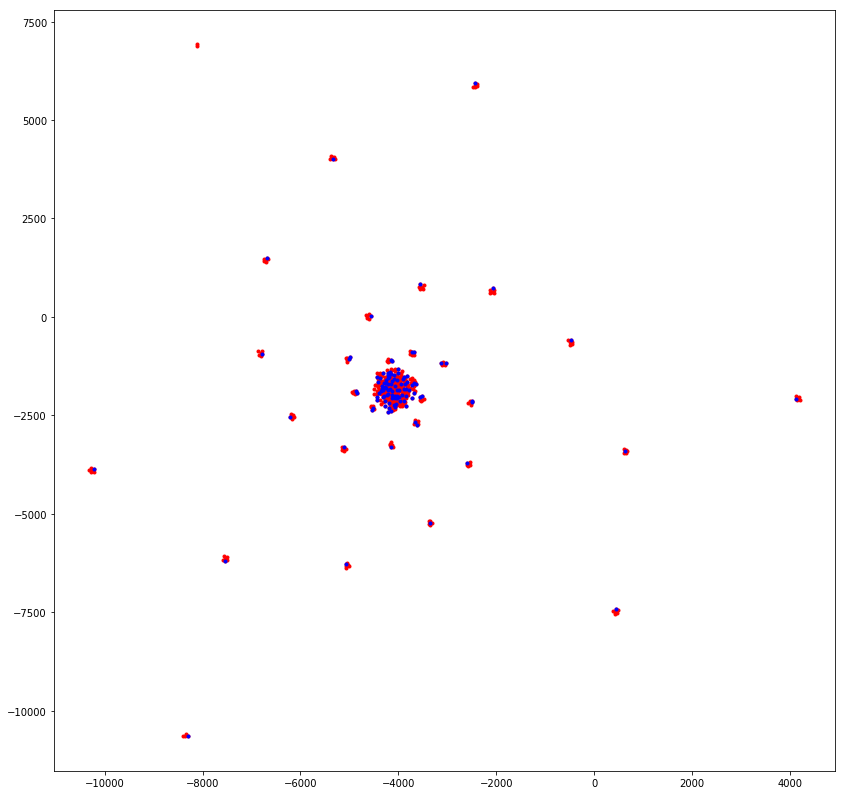

In [6]:
nfreqwin = 1
ntimes = 61
rmax = 10000.0
dec = -40.0 * u.deg
frequency = numpy.linspace(1e8, 1.3e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.3e8]
times = numpy.linspace(-300, 300.0, ntimes) * numpy.pi / (3600.0 * 12.0)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=dec, frame='icrs', equinox='J2000')
low = create_named_configuration('LOWBD2', rmax=rmax)
print('Configuration has %d stations' % len(low.data))
plt.clf()
plt.plot(low.xyz[:,2], low.xyz[:,0], '.', color='red')
centre = numpy.mean(low.xyz, axis=0)
distance = numpy.hypot(low.xyz[:, 0] - centre[0],
                       low.xyz[:, 1] - centre[1],
                       low.xyz[:, 2] - centre[2])
lowouter = low.data[distance > 1000.0][::6]
lowcore = low.data[distance < 1000.0][::3]
low.data = numpy.hstack((lowcore, lowouter))
plt.plot(low.xyz[:,2], low.xyz[:,0], '.', color='blue')
print('Thinned configuration has %d stations' % len(lowcore.data))
plt.show()

blockvis = create_blockvisibility(
    low,
    times,
    frequency=frequency,
    channel_bandwidth=channel_bandwidth,
    weight=1.0,
    phasecentre=phasecentre,
    polarisation_frame=PolarisationFrame("stokesI"),
    zerow=True)

### Find sampling, image size, etc

In [7]:
wprojection_planes = 1
vis = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(vis, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']

### Generate the model from the GLEAM catalog, including application of the primary beam.

Number of components 162


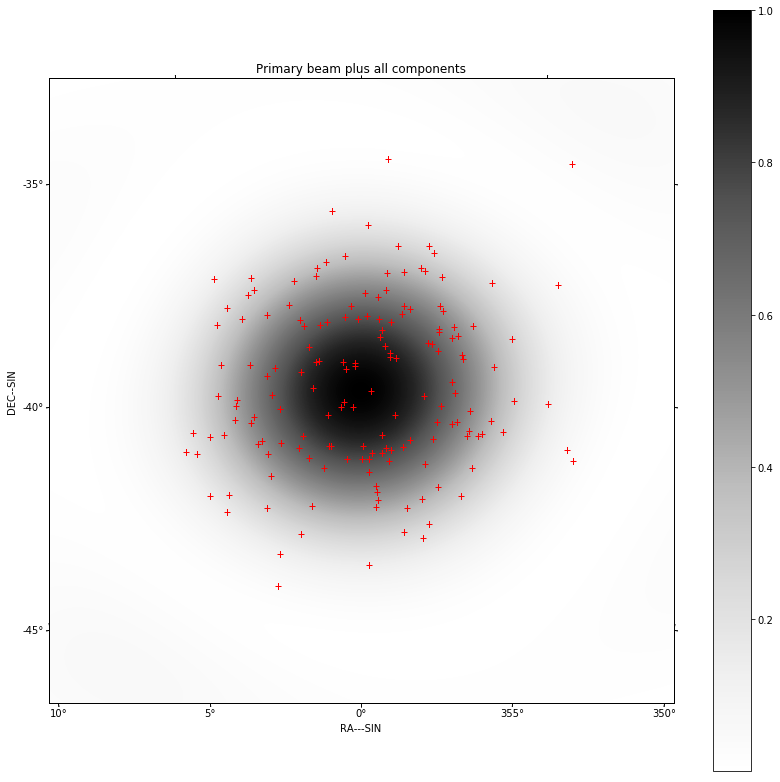

In [8]:
flux_limit=0.2
beam = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)
beam = create_low_test_beam(beam)

original_gleam_components = create_low_test_skycomponents_from_gleam(
    flux_limit=flux_limit,
    phasecentre=phasecentre,
    frequency=frequency,
    polarisation_frame=PolarisationFrame('stokesI'),
    radius=0.2)

all_components = apply_beam_to_skycomponent(original_gleam_components,
                                                 beam)

all_components = filter_skycomponents_by_flux(all_components, flux_min=flux_limit)

show_image(
    beam,
    components=all_components,
    cm='Greys',
    title='Primary beam plus all components')

lprint("Number of components %d" % len(all_components))

### Fill the gaintables from the ionospheric screen model

In [9]:
screen = import_image_from_fits('screens/low_screen_5000.0r0_0.100rate.fits')
all_gaintables = create_gaintable_from_screen(blockvis, all_components, screen, scale=1.0)

### Now assemble the skymodels

In [10]:
empty = create_image_from_visibility(
    blockvis,
    npixel=128,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

gleam_skymodel_noniso = [SkyModel(components=[all_components[i]], image=empty, 
                           gaintable=all_gaintables[i])
                  for i, sm in enumerate(all_components)]

gleam_skymodel_iso = [SkyModel(components=all_components, image=empty, 
                           gaintable=all_gaintables[0])]

In [11]:
from data_models.data_model_helpers import export_skymodel_to_hdf5
export_skymodel_to_hdf5(gleam_skymodel_noniso, 
                        'results/low-sims-mpc-noniso-skymodel-rmax%.1f.hdf5' %rmax)
export_skymodel_to_hdf5(gleam_skymodel_iso,
                        'results/low-sims-mpc-iso-skymodel-rmax%.1f.hdf5' %rmax)

In [12]:
from wrappers.arlexecute.visibility.coalesce import convert_visibility_to_blockvisibility

all_skymodel_iso_blockvis = copy_visibility(blockvis, zero=True)
all_skymodel_iso_vis = convert_blockvisibility_to_visibility(all_skymodel_iso_blockvis)

In [13]:
from workflows.arlexecute.skymodel.skymodel_arlexecute import predict_skymodel_list_arlexecute_workflow

future_vis = arlexecute.scatter([all_skymodel_iso_vis])
result = predict_skymodel_list_arlexecute_workflow(future_vis, 
                                                   gleam_skymodel_iso, 
                                                   context='2d', docal=True)
all_skymodel_iso_vis = arlexecute.compute(result, sync=True)[0]

all_skymodel_iso_blockvis = convert_visibility_to_blockvisibility(all_skymodel_iso_vis)
    
export_blockvisibility_to_hdf5(all_skymodel_iso_blockvis, 
                               'results/low-sims-mpc-skymodel_iso_blockvis_rmax%.1f.hdf5' % rmax)

arlexecute.compute: Execution using Dask took 23.515 seconds


### Now predict the visibility for each skymodel and apply the gaintable for that skymodel, returning a list of visibilities, one for each skymodel. We then sum these to obtain the total predicted visibility. All images and skycomponents in the same skymodel get the same gaintable applied which means that in this case each skycomponent has a separate gaintable.

In [ ]:
all_skymodel_noniso_blockvis = copy_visibility(blockvis, zero=True)
all_skymodel_noniso_vis = convert_blockvisibility_to_visibility(all_skymodel_noniso_blockvis)

ngroup=n_workers
future_vis = arlexecute.scatter(all_skymodel_noniso_vis)
chunks = [gleam_skymodel_noniso[i:i + ngroup] for i in range(0, len(gleam_skymodel_noniso), ngroup)]
for chunk in chunks:
    result = predict_skymodel_list_arlexecute_workflow(future_vis, chunk, context='2d', docal=True)
    work_vis = arlexecute.compute(result, sync=True)
    for w in work_vis:
        all_skymodel_noniso_vis.data['vis'] += w.data['vis']

all_skymodel_noniso_blockvis = convert_visibility_to_blockvisibility(all_skymodel_noniso_vis)
    
export_blockvisibility_to_hdf5(all_skymodel_noniso_blockvis, 
                               'results/low-sims-mpc-skymodel_noniso_blockvis_rmax%.1f.hdf5' % rmax)

arlexecute.compute: Execution using Dask took 8.447 seconds
arlexecute.compute: Execution using Dask took 8.278 seconds
arlexecute.compute: Execution using Dask took 8.307 seconds
arlexecute.compute: Execution using Dask took 8.174 seconds
arlexecute.compute: Execution using Dask took 8.029 seconds
arlexecute.compute: Execution using Dask took 8.336 seconds
arlexecute.compute: Execution using Dask took 8.094 seconds
arlexecute.compute: Execution using Dask took 8.132 seconds
arlexecute.compute: Execution using Dask took 8.008 seconds
arlexecute.compute: Execution using Dask took 8.052 seconds
arlexecute.compute: Execution using Dask took 8.189 seconds
arlexecute.compute: Execution using Dask took 8.211 seconds
arlexecute.compute: Execution using Dask took 8.040 seconds
arlexecute.compute: Execution using Dask took 8.083 seconds
arlexecute.compute: Execution using Dask took 8.159 seconds
arlexecute.compute: Execution using Dask took 8.046 seconds
arlexecute.compute: Execution using Dask

arlexecute.compute: Execution using Dask took 8.025 seconds
arlexecute.compute: Execution using Dask took 8.084 seconds
arlexecute.compute: Execution using Dask took 8.308 seconds
arlexecute.compute: Execution using Dask took 7.997 seconds
arlexecute.compute: Execution using Dask took 7.917 seconds
arlexecute.compute: Execution using Dask took 8.261 seconds
arlexecute.compute: Execution using Dask took 7.843 seconds
arlexecute.compute: Execution using Dask took 8.256 seconds
arlexecute.compute: Execution using Dask took 8.221 seconds
arlexecute.compute: Execution using Dask took 8.231 seconds
arlexecute.compute: Execution using Dask took 7.984 seconds
arlexecute.compute: Execution using Dask took 7.926 seconds
arlexecute.compute: Execution using Dask took 8.185 seconds
arlexecute.compute: Execution using Dask took 8.061 seconds
arlexecute.compute: Execution using Dask took 8.196 seconds
arlexecute.compute: Execution using Dask took 8.144 seconds
arlexecute.compute: Execution using Dask